In [29]:
# Dependencies
import pandas as pd
from prophet import Prophet
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date
import numpy as np
from sklearn.model_selection import ParameterGrid
import seaborn as sns
from workalendar.usa import UnitedStates
from datetime import date
import warnings
import itertools
import random
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [2]:
# Read the CSV files
csv_file = '../data/store.csv'

# Save CSV files into DataFrame
df = pd.read_csv(csv_file)

# Display DataFrame
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [3]:
# Filter the DataFrame based on store and item values
filtered_df = df[(df['store'] == 1) & (df['item'] == 1)]

# Select the required columns and rename them
history_pd = filtered_df[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

# Sort the DataFrame by date
history_pd = history_pd.sort_values(by='ds')

# Reset the index of the DataFrame
history_pd = history_pd.reset_index(drop=True)

# Display DataFrame
history_pd

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
...,...,...
1821,2017-12-27,14
1822,2017-12-28,19
1823,2017-12-29,15
1824,2017-12-30,27


In [4]:
# disable informational messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

# set model parameters
model = Prophet(
  interval_width=0.95,
  growth='linear',
  daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  seasonality_mode='multiplicative'
  )
 
# fit the model to historical data
model.fit(history_pd)

15:47:27 - cmdstanpy - INFO - Chain [1] start processing
15:47:27 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Define a dataset including both historical dates & 90-days beyond the last available date
future_pd = model.make_future_dataframe(
  periods=90, 
  freq='d', 
  include_history=True
  )
 
# Predict over the dataset
forecast_pd = model.predict(future_pd)
 
# Display results
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,15.607400,1.499759,18.465345,15.607400,15.607400,-0.356003,-0.356003,-0.356003,-0.088820,-0.088820,-0.088820,-0.267183,-0.267183,-0.267183,0.0,0.0,0.0,10.051119
1,2013-01-02,15.613104,1.871247,19.409148,15.613104,15.613104,-0.325666,-0.325666,-0.325666,-0.059012,-0.059012,-0.059012,-0.266654,-0.266654,-0.266654,0.0,0.0,0.0,10.528451
2,2013-01-03,15.618808,2.469277,19.622828,15.618808,15.618808,-0.292318,-0.292318,-0.292318,-0.025382,-0.025382,-0.025382,-0.266936,-0.266936,-0.266936,0.0,0.0,0.0,11.053147
3,2013-01-04,15.624511,3.378815,20.991392,15.624511,15.624511,-0.216337,-0.216337,-0.216337,0.051654,0.051654,0.051654,-0.267991,-0.267991,-0.267991,0.0,0.0,0.0,12.244353
4,2013-01-05,15.630215,5.339386,22.631659,15.630215,15.630215,-0.118351,-0.118351,-0.118351,0.151404,0.151404,0.151404,-0.269755,-0.269755,-0.269755,0.0,0.0,0.0,13.780369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,2018-03-27,22.766163,11.767868,28.653425,22.738232,22.793584,-0.118400,-0.118400,-0.118400,-0.088820,-0.088820,-0.088820,-0.029580,-0.029580,-0.029580,0.0,0.0,0.0,20.070650
1912,2018-03-28,22.767908,12.654170,29.597982,22.739642,22.796269,-0.085724,-0.085724,-0.085724,-0.059012,-0.059012,-0.059012,-0.026712,-0.026712,-0.026712,0.0,0.0,0.0,20.816146
1913,2018-03-29,22.769652,12.836983,30.871504,22.740894,22.798919,-0.049246,-0.049246,-0.049246,-0.025382,-0.025382,-0.025382,-0.023864,-0.023864,-0.023864,0.0,0.0,0.0,21.648336
1914,2018-03-30,22.771397,14.644803,31.994325,22.741716,22.801126,0.030675,0.030675,0.030675,0.051654,0.051654,0.051654,-0.020980,-0.020980,-0.020980,0.0,0.0,0.0,23.469900


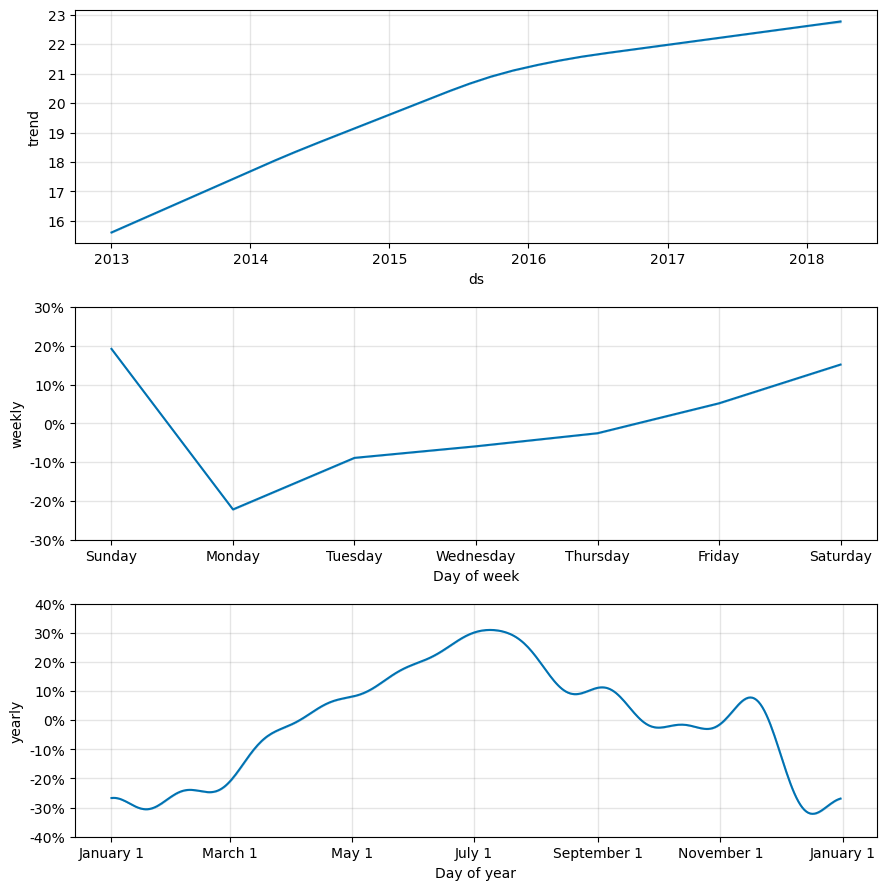

In [6]:
trends_fig = model.plot_components(forecast_pd)

(17171.75, 17626.75)

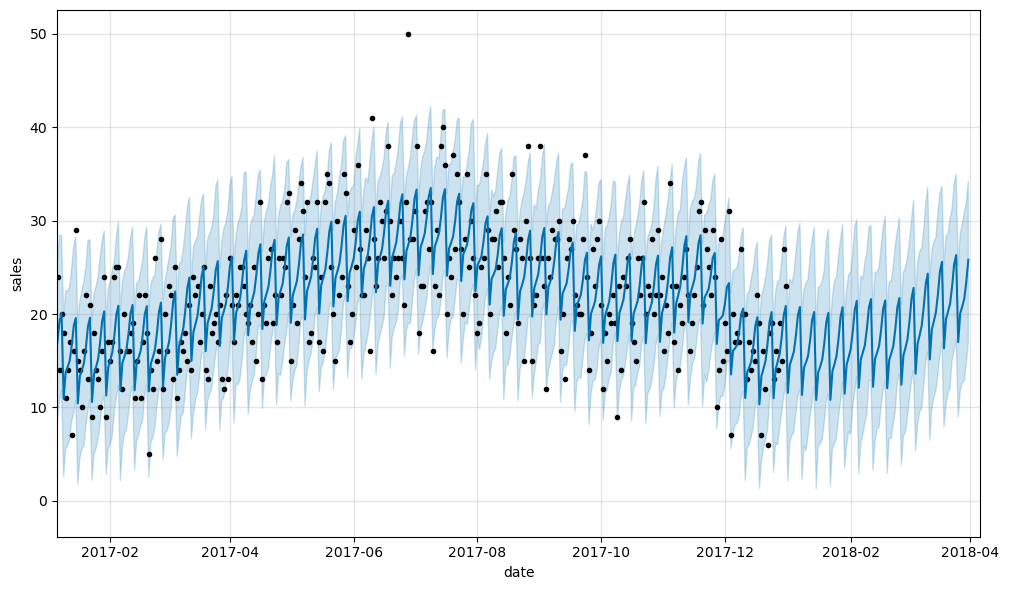

In [7]:
predict_fig = model.plot( forecast_pd, xlabel='date', ylabel='sales')
 
# adjust figure to display dates from last year + the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

In [8]:
# Convert the 'ds' column to datetime format if it's not already
history_pd['ds'] = pd.to_datetime(history_pd['ds'])
forecast_pd['ds'] = pd.to_datetime(forecast_pd['ds'])
 
# get historical actuals & predictions for comparison
actuals_pd = history_pd[history_pd['ds'].dt.date < date(2017, 1, 1)]['y']
predicted_pd = forecast_pd[forecast_pd['ds'].dt.date < date(2017, 1, 1)]['yhat']
 
# calculate evaluation metrics
mae = mean_absolute_error(actuals_pd, predicted_pd)
mse = mean_squared_error(actuals_pd, predicted_pd)
rmse = sqrt(mse)
 
# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

MAE: 3.4070271209628746
MSE: 18.69332381240947
RMSE: 4.323577663510796


In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
mape = mean_absolute_percentage_error(actuals_pd, predicted_pd)
 
print('MAPE: {}'.format(mape))

MAPE: 20.412511952412476


In [10]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [11]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
 
# Create holidays DataFrame
holiday = pd.DataFrame([])
holidays = UnitedStates()
years = [2013, 2014, 2015, 2016]
 
for year in years:
    for date, name in holidays.holidays(year):
        holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
 
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
 
 
# Set start and end dates for the evaluation
strt = '2013-01-01'
end = '2016-12-31'
 
# Grid of parameters to search
grid = {'changepoint_prior_scale': [0.1, 0.5, 0.001, 0.15],
        'holidays_prior_scale': [0.1, 0.5, 0.001, 0.15],
        'n_changepoints': [100, 200, 300],
        'seasonality_mode': ['multiplicative', 'additive']}
 
# Perform the search
model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])
for p in itertools.product(*grid.values()):
    params = dict(zip(grid.keys(), p))
    print(params)
 
    train_model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                          holidays_prior_scale=params['holidays_prior_scale'],
                          n_changepoints=params['n_changepoints'],
                          seasonality_mode=params['seasonality_mode'],
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          yearly_seasonality=True,
                          holidays=holiday,
                          interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(history_pd)
    train_forecast = train_model.make_future_dataframe(periods=0, freq='D', include_history=True)
    train_forecast = train_model.predict(train_forecast)
    test = train_forecast[(train_forecast['ds'] >= pd.to_datetime(strt)) & (train_forecast['ds'] <= pd.to_datetime(end))][['ds', 'yhat']]
    Actual = history_pd[(history_pd['ds'] >= pd.to_datetime(strt)) & (history_pd['ds'] <= pd.to_datetime(end))]
    MAPE = mean_absolute_percentage_error(Actual['y'], abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------', MAPE)
    model_parameters = model_parameters.append({'MAPE': MAPE, 'Parameters': params}, ignore_index=True)


15:47:28 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:47:29 - cmdstanpy - INFO - Chain [1] done processing
15:47:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.373660666560394
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:47:29 - cmdstanpy - INFO - Chain [1] done processing
15:47:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.405567359794567
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:47:30 - cmdstanpy - INFO - Chain [1] done processing
15:47:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.381892694105144
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:47:30 - cmdstanpy - INFO - Chain [1] done processing
15:47:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.41007551637385
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:47:31 - cmdstanpy - INFO - Chain [1] done processing
15:47:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.376275228470035
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:47:32 - cmdstanpy - INFO - Chain [1] done processing
15:47:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.407512938976367
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:47:32 - cmdstanpy - INFO - Chain [1] done processing
15:47:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.344471065941857
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:47:33 - cmdstanpy - INFO - Chain [1] done processing
15:47:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.39966729656603
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:47:33 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.352262911673254
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.401568489440578
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:47:35 - cmdstanpy - INFO - Chain [1] done processing
15:47:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.348036022814362
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:47:36 - cmdstanpy - INFO - Chain [1] done processing
15:47:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.39709143642595
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:47:37 - cmdstanpy - INFO - Chain [1] done processing
15:47:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.40584442383525
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:47:37 - cmdstanpy - INFO - Chain [1] done processing
15:47:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.47187706483588
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:47:38 - cmdstanpy - INFO - Chain [1] done processing
15:47:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.408851196534506
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:47:38 - cmdstanpy - INFO - Chain [1] done processing
15:47:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.471887858223504
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:47:39 - cmdstanpy - INFO - Chain [1] done processing
15:47:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.41386590485462
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:47:40 - cmdstanpy - INFO - Chain [1] done processing
15:47:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.469711970916475
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:47:40 - cmdstanpy - INFO - Chain [1] done processing
15:47:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.36177463968288
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:47:41 - cmdstanpy - INFO - Chain [1] done processing
15:47:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.399201747723684
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:47:41 - cmdstanpy - INFO - Chain [1] done processing
15:47:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.359740770186917
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:47:42 - cmdstanpy - INFO - Chain [1] done processing
15:47:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.39797038990237
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:47:43 - cmdstanpy - INFO - Chain [1] done processing
15:47:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.364740825973023
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:47:44 - cmdstanpy - INFO - Chain [1] done processing
15:47:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.39826143224466
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:47:44 - cmdstanpy - INFO - Chain [1] done processing
15:47:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.34587830183697
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:47:45 - cmdstanpy - INFO - Chain [1] done processing
15:47:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.28853492121307
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:47:46 - cmdstanpy - INFO - Chain [1] done processing
15:47:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.34304134894904
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:47:47 - cmdstanpy - INFO - Chain [1] done processing
15:47:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.287249132883726
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:47:48 - cmdstanpy - INFO - Chain [1] done processing
15:47:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.34534432628676
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:47:50 - cmdstanpy - INFO - Chain [1] done processing
15:47:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.287459794060577
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:47:51 - cmdstanpy - INFO - Chain [1] done processing
15:47:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.314529271052557
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:47:52 - cmdstanpy - INFO - Chain [1] done processing
15:47:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.274532149330486
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:47:54 - cmdstanpy - INFO - Chain [1] done processing
15:47:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.315085421048796
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:47:55 - cmdstanpy - INFO - Chain [1] done processing
15:47:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.274942290119643
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:47:56 - cmdstanpy - INFO - Chain [1] done processing
15:47:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.312526741060253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:47:58 - cmdstanpy - INFO - Chain [1] done processing
15:47:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.273737501523723
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:01 - cmdstanpy - INFO - Chain [1] done processing
15:48:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.286913837787864
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:02 - cmdstanpy - INFO - Chain [1] done processing
15:48:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.352015861718662
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:05 - cmdstanpy - INFO - Chain [1] done processing
15:48:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.3199007497828
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:06 - cmdstanpy - INFO - Chain [1] done processing
15:48:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.35177176321441
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:10 - cmdstanpy - INFO - Chain [1] done processing
15:48:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.32931646493619
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:12 - cmdstanpy - INFO - Chain [1] done processing
15:48:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.35160670700458
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:13 - cmdstanpy - INFO - Chain [1] done processing
15:48:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.332052712396887
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:14 - cmdstanpy - INFO - Chain [1] done processing
15:48:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.282154132198787
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:14 - cmdstanpy - INFO - Chain [1] done processing
15:48:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.334976722222002
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:16 - cmdstanpy - INFO - Chain [1] done processing
15:48:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.28108302761654
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:17 - cmdstanpy - INFO - Chain [1] done processing
15:48:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.332968139036538
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:19 - cmdstanpy - INFO - Chain [1] done processing
15:48:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.280609046495986
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:20 - cmdstanpy - INFO - Chain [1] done processing
15:48:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.376831097790507
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:20 - cmdstanpy - INFO - Chain [1] done processing
15:48:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.55127032010375
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:21 - cmdstanpy - INFO - Chain [1] done processing
15:48:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.113838863613374
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:22 - cmdstanpy - INFO - Chain [1] done processing
15:48:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.229056112139048
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:23 - cmdstanpy - INFO - Chain [1] done processing
15:48:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.237949588230574
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:25 - cmdstanpy - INFO - Chain [1] done processing
15:48:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.4195730891871
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:25 - cmdstanpy - INFO - Chain [1] done processing
15:48:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.327534860583143
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:26 - cmdstanpy - INFO - Chain [1] done processing
15:48:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.147085792610763
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:26 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.057963704877906
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:27 - cmdstanpy - INFO - Chain [1] done processing
15:48:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.177949729349272
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:28 - cmdstanpy - INFO - Chain [1] done processing
15:48:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.386231284297693
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:30 - cmdstanpy - INFO - Chain [1] done processing
15:48:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.361937056256775
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:30 - cmdstanpy - INFO - Chain [1] done processing
15:48:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.15674942510943
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:31 - cmdstanpy - INFO - Chain [1] done processing
15:48:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.137633414885062
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:31 - cmdstanpy - INFO - Chain [1] done processing
15:48:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.173475144347524
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:32 - cmdstanpy - INFO - Chain [1] done processing
15:48:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.155265225396267
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:33 - cmdstanpy - INFO - Chain [1] done processing
15:48:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.204333545072643
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:34 - cmdstanpy - INFO - Chain [1] done processing
15:48:34 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.167363242959535
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.374550168865653
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:35 - cmdstanpy - INFO - Chain [1] done processing
15:48:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.263708683162594
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:35 - cmdstanpy - INFO - Chain [1] done processing
15:48:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.264038655327553
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:36 - cmdstanpy - INFO - Chain [1] done processing
15:48:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.17232460352407
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:37 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.271006309924445
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:39 - cmdstanpy - INFO - Chain [1] done processing
15:48:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.300878711846025
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:39 - cmdstanpy - INFO - Chain [1] done processing
15:48:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.37584302601508
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:40 - cmdstanpy - INFO - Chain [1] done processing
15:48:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.38590224230557
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:40 - cmdstanpy - INFO - Chain [1] done processing
15:48:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.376872713161028
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:41 - cmdstanpy - INFO - Chain [1] done processing
15:48:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.367322913923765
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:42 - cmdstanpy - INFO - Chain [1] done processing
15:48:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.376778174158943
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.1, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:43 - cmdstanpy - INFO - Chain [1] done processing
15:48:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.389721182344957
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:44 - cmdstanpy - INFO - Chain [1] done processing
15:48:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.34147389591612
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:44 - cmdstanpy - INFO - Chain [1] done processing
15:48:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.383949217772496
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:45 - cmdstanpy - INFO - Chain [1] done processing
15:48:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.342944743023992
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:46 - cmdstanpy - INFO - Chain [1] done processing
15:48:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.37170506007985
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:47 - cmdstanpy - INFO - Chain [1] done processing
15:48:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.346099002040578
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.5, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:47 - cmdstanpy - INFO - Chain [1] done processing
15:48:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.377746769161504
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:48 - cmdstanpy - INFO - Chain [1] done processing
15:48:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.406351646011885
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:48 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.46132862589392
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:49 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.406884211856312
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.001, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:50 - cmdstanpy - INFO - Chain [1] done processing
15:48:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.45507787414863
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:50 - cmdstanpy - INFO - Chain [1] done processing
15:48:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.407465972694503
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.001, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.451303218187842
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.36249613801689
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.375721127104157
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.36384030474902
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.15, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:48:54 - cmdstanpy - INFO - Chain [1] done processing
15:48:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.376023303074096
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'multiplicative'}


15:48:55 - cmdstanpy - INFO - Chain [1] done processing
15:48:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.36131222570134
{'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.15, 'n_changepoints': 300, 'seasonality_mode': 'additive'}


15:48:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.375076714277842


In [12]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,20.057964,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,20.113839,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,20.137633,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,20.147086,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,20.155265,"{'changepoint_prior_scale': 0.001, 'holidays_p..."


In [13]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.001,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 200,
 'seasonality_mode': 'multiplicative'}

In [14]:
def train_prophet_model(store, item):

    # Load data into a Pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Filter DataFrame for store and item
    df = df[(df['store'] == store) & (df['item'] == item)]
 
    # Select ds and y columns
    df = df[['date', 'sales']]
    df.columns = ['ds', 'y']
 
    # Set model parameters using best parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.001,
        holidays_prior_scale=0.5,
        n_changepoints=200,
        seasonality_mode='multiplicative'
    )
    
    # Train the Prophet model
    model.fit(df)
 
    return model

In [15]:
# Get the unique stores and items
unique_stores = df['store'].unique().tolist()
unique_items = df['item'].unique().tolist()

In [16]:
# Initialize a dictionary to store the models
models = {}
 
# Iterate through all store and item combos
for store in unique_stores:
    for item in unique_items:
        model = train_prophet_model(store, item)
        models[(store, item)] = model


15:48:56 - cmdstanpy - INFO - Chain [1] start processing
15:48:56 - cmdstanpy - INFO - Chain [1] done processing
15:48:57 - cmdstanpy - INFO - Chain [1] start processing
15:48:57 - cmdstanpy - INFO - Chain [1] done processing
15:48:57 - cmdstanpy - INFO - Chain [1] start processing
15:48:57 - cmdstanpy - INFO - Chain [1] done processing
15:48:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:48:57 - cmdstanpy - INFO - Chain [1] start processing
15:49:20 - cmdstanpy - INFO - Chain [1] done processing
15:49:20 - cmdstanpy - INFO - Chain [1] start processing
15:49:20 - cmdstanpy - INFO - Chain [1] done processing
15:49:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:49:20 - cmdstanpy - INFO - Chain [1] start processing
15:49:47 - cmdstanpy - INFO - Chain [1] done processing
15:49:48 - cmd

In [23]:
# Read in the csv file for test_data
test_df = pd.read_csv('../data/processed_data/test_data.csv')

# Convert the data column to datetime in pandas
test_df['date'] = pd.to_datetime(test_df['date'])

# Rename the date column to ds
test_df = test_df.rename(columns={'date': 'ds'})

# Display the results
test_df

,ds,store,item,sales
0,2017-01-01,1,1,19
1,2017-01-02,1,1,15
2,2017-01-03,1,1,10
3,2017-01-04,1,1,16
4,2017-01-05,1,1,14
...,...,...,...,...
182495,2017-12-27,10,50,63
182496,2017-12-28,10,50,59
182497,2017-12-29,10,50,74
182498,2017-12-30,10,50,62


In [21]:
# Create a function that generates future predictions for a given store and item
def predict_sales(store, item, models, start_date='2017-01-01', end_date='2017-12-31'):
    model = models[(store, item)]
    
    future = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=['ds'])
    forecast = model.predict(future)
    
    forecast = forecast[['ds', 'yhat']]
    forecast['store'] = store
    forecast['item'] = item
    
    return forecast


In [22]:
# Generate predictions for each store and item combination
predictions = []

for store in unique_stores:
    for item in unique_items:
        forecast = predict_sales(store, item, models)
        predictions.append(forecast)

predictions_df = pd.concat(predictions).reset_index(drop=True)

In [25]:
# Merge the predictions with the test data, and calculate the error
results_df = test_df.merge(predictions_df, on=['ds', 'store', 'item'], how='inner')
results_df['error'] = results_df['sales'] - results_df['yhat']

# Display the results
results_df

,ds,store,item,sales,yhat,error
0,2017-01-01,1,1,19,20.066590,-1.066590
1,2017-01-02,1,1,15,9.543506,5.456494
2,2017-01-03,1,1,10,12.996660,-2.996660
3,2017-01-04,1,1,16,13.801228,2.198772
4,2017-01-05,1,1,14,14.700574,-0.700574
...,...,...,...,...,...,...
182495,2017-12-27,10,50,63,56.565315,6.434685
182496,2017-12-28,10,50,59,62.090630,-3.090630
182497,2017-12-29,10,50,74,67.350890,6.649110
182498,2017-12-30,10,50,62,72.526502,-10.526502


In [26]:
# Define a function to calculate metrics
def calculate_metrics(df):
    mae = mean_absolute_error(df['sales'], df['yhat'])
    mse = mean_squared_error(df['sales'], df['yhat'])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((df['sales'] - df['yhat']) / df['sales'])) * 100
    
    return mae, mse, rmse, mape

In [27]:
# Calculate the metrics for each store and item combination and store them in a DataFrame
metrics_data = []

for store in unique_stores:
    for item in unique_items:
        store_item_df = results_df[(results_df['store'] == store) & (results_df['item'] == item)]
        mae, mse, rmse, mape = calculate_metrics(store_item_df)
        
        metrics_data.append({
            'store': store,
            'item': item,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        })

metrics_df = pd.DataFrame(metrics_data)

In [28]:
# Display the results
metrics_df

,store,item,MAE,MSE,RMSE,MAPE
0,1,1,3.917011,23.424752,4.839912,20.210647
1,1,2,6.656593,70.737309,8.410548,12.011237
2,1,3,4.989993,39.784662,6.307508,14.708855
3,1,4,3.841695,23.014217,4.797314,19.818133
4,1,5,3.227345,17.016480,4.125104,21.111290
...,...,...,...,...,...,...
495,10,46,7.374007,84.206297,9.176399,10.741529
496,10,47,4.563882,33.448566,5.783474,18.042748
497,10,48,6.973658,77.043036,8.777416,11.471564
498,10,49,5.056803,41.613294,6.450837,15.458179


In [30]:
# Connect to local database
protocol = 'postgresql'
username = 'postgres'
password = 'postgres'
host = 'localhost'
port = 5432
database_name = 'model'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [31]:
# Load the Dataframe into Postgres
results_df.to_sql(name='results', con=engine, if_exists='replace', index=False)
# Load the Dataframe into Postgres
metrics_df.to_sql(name='metrics', con=engine, if_exists='replace', index=False)

500